In [1]:
#Bibliotecas
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import timeit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import LeavePOut

#Funções de plotagem interativa
%matplotlib notebook

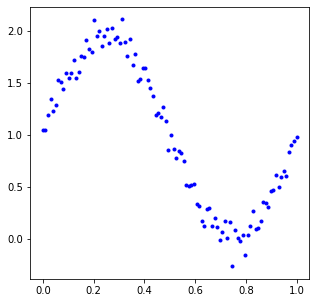

In [3]:
df = pd.read_csv('./reg_poli.csv', header=None)
                 
x = df[0].to_numpy()
y = df[1].to_numpy()
                 
x = x.reshape(len(x), 1)
y = y.reshape(len(y), 1)

fig = plt.figure(figsize = (5, 5))
plt.plot(x, y, 'b.')

In [5]:
include_bias = False

#Definição dos polinômios a serem testados
degrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

#Separação entre os conjuntos de treinamento e validação (treinamento 70% e validação 30%)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=10)

#Mostro o # de elementos em cada conjunto (treinamento ou validação)
print('tamanho conjunto de treinamento:', len(y_train))
print('tamanho conjunto de validação:', len(y_val))

tamanho conjunto de treinamento: 70
tamanho conjunto de validação: 30


# HoldOut

In [7]:
#Crio vetores para armazenar os valores a serem obtidos
mean_vec = []
std_vec = []

#Crio loop que será executado 12 vezes
for d in range(1, 12):
    
    #Criar o polinômio a ser utilizado
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    
    #Habilitar o escalonamento de features
    std_scaler = StandardScaler()
    
    #Habilitar a regressão linear
    lin_reg = LinearRegression()
    
    #Definir o fluxo de ações a serem executadas
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    
    #Realizo o treinamento do modelo, utilizando os dados (features e labels) de treinamento.
    polynomial_regression.fit(x_train, y_train)
    
    #Realizo predições utilizando as features de validação (gero y de validação utilizando as features de validação)
    y_val_predict = polynomial_regression.predict(x_val)
    
    #Calcular a minha raiz do erro médio entre  y_val e y_predict
    mean_vec.append(np.sqrt(mean_squared_error(y_val, y_val_predict)))
    

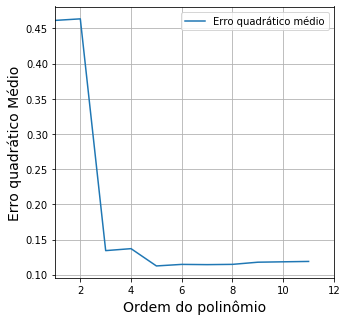

In [8]:
#Gero gráfico com os resultados do HoldOut (Erro Quadrático médio vs. Ordem do polinômio)
plt.figure(figsize=(5, 5))
plt.plot(range(1, 12), mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Erro quadrático Médio', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

# K-Fold

In [9]:
#Criar 10 folds com elementos não repetidos (shuffle = true)
kfold = KFold(n_splits=10, shuffle=True, random_state=100)

#Criar vetores para armazenamento dos valores a serem obtidos
mean_vec = []
std_vec = []

#Loop que será executado 12x
for d in range(1, 12):
    
    #Criar o polinômio
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    
    #Habilitar o escalonamento de features
    std_scaler = StandardScaler()
    
    #Habilitar a regressão linear
    lin_reg = LinearRegression()

    #Criar o fluxo de ações
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    
    #Calcular o score (desempenho) da regressão polinomial, utilizando os folds previamente criados (kfold)
    lin_scores = cross_val_score(polynomial_regression, x, y, scoring='neg_mean_squared_error', cv=kfold)
    
    #Faço adequação dos vetores de desempenho, média e desvio padrão (adiciono os valores obtidos a cada vetor)
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())

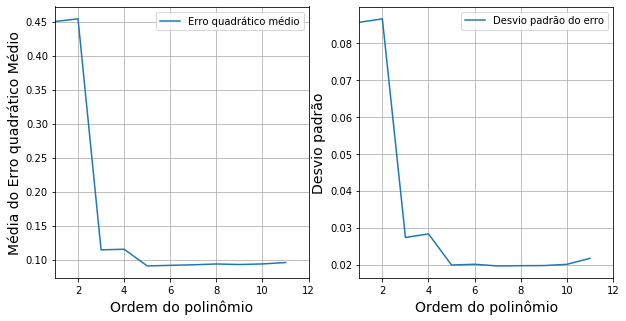

In [10]:
#Gero a área a ser plotada
plt.figure(figsize=(10, 5))

#Ploto a primeira figura (erro quadrático médio vs. ordem do polinômio)
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 12), mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do Erro quadrático Médio', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

#Ploto a segunda figura (desvio padrão vs. ordem do polinômio)
ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 12), std_vec,  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

# Leave-P-Out (P = 1)

In [11]:
#Inicializar o Leave-P-Out (P = 1)
lpocv = LeavePOut(p=1)

#Criar os vetores para armazenar os dados a serem obtidos (erro quadrático médio e desvio padrão)
mean_vec = []
std_vec = []

#Criar o loop que será executado 12x
for d in range(1, 12):
    
    #Criar o polinômio
    poly_features = PolynomialFeatures(degree=d, include_bias=include_bias)
    
    #Habilitar o escalonamento de features
    std_scaler = StandardScaler()
    
    #Habilitar a regressão linear
    lin_reg = LinearRegression()

    #Criar o fluxo de funções que devem ser executadas
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    
    #Calcular o desempenho (score) da validação cruzada (leave-P-Out)
    lin_scores = cross_val_score(polynomial_regression, x, y, scoring='neg_mean_squared_error', cv=lpocv)
    
    #Adicionar aos vetores, os valores de erro quadrático médio e desvio padrão obtidos
    scores = np.sqrt(-lin_scores)
    mean_vec.append(scores.mean())
    std_vec.append(scores.std())
    

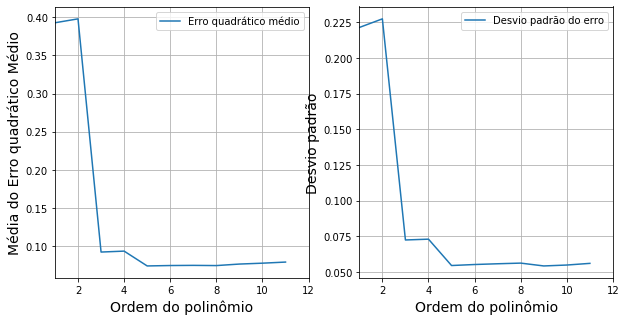

In [12]:
#Gerar a área a ser plotada
plt.figure(figsize=(10, 5))

#Gerar a primeira figura (erro quadrático médio vs. ordem do polinômio)
ax = plt.subplot(1, 2, 1)
plt.plot(range(1, 12), mean_vec,  label='Erro quadrático médio')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Média do Erro quadrático Médio', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

#Gerar a segunda figura (desvio padrão vs. ordem do polinômio)
ax = plt.subplot(1, 2, 2)
plt.plot(range(1, 12), std_vec,  label='Desvio padrão do erro')
plt.xlabel('Ordem do polinômio', fontsize=14)
plt.ylabel('Desvio padrão', fontsize=14)
plt.xticks(range(0, 13, 2))
plt.xlim([1, 12])
plt.legend()
plt.grid()

# Curvas de Aprendizado

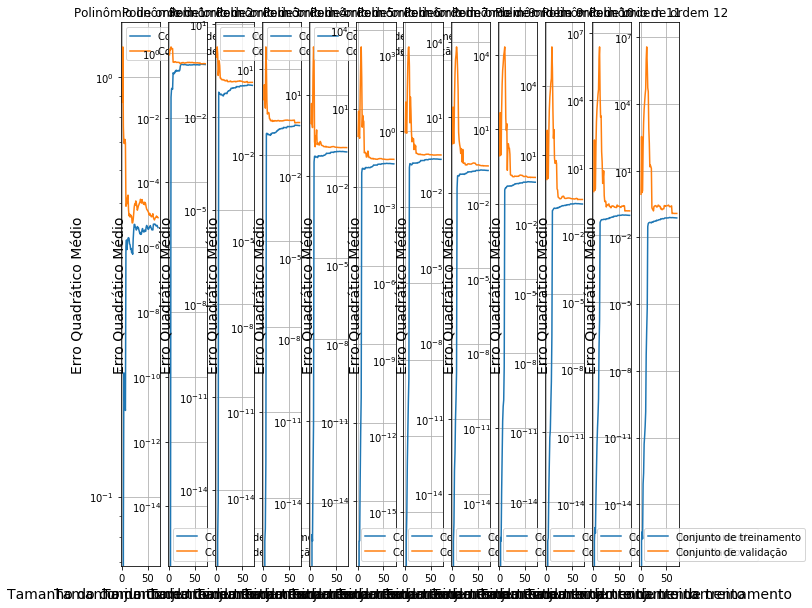

In [13]:
#Gerar área a ser plotada
plt.figure(figsize= (10,10))

#Loop que será executado 12x 
for i in range(len(degrees)):
    
    #Gerar a primeira sub-área para a i-ésima ordem a ser testada
    ax = plt.subplot(1, len(degrees), i + 1)
    
    #Gerar polinômio de ordem i
    poly_features = PolynomialFeatures(degree=degrees[i], include_bias=include_bias)
    
    #Habilitar o escalonamento de features
    std_scaler = StandardScaler()
    
    #Habilitar a regressão linear
    lin_reg = LinearRegression()

    #Criar o fluxo de ações a serem realizadas (Polinômio, escalonamento de features e regressão linear)
    polynomial_regression = Pipeline([
        ("poly_features", poly_features),
        ("std_scaler", std_scaler),
        ("lin_reg", lin_reg),
    ])
    
    #Criar vetores para armazenar os erros de treinamento e de validação
    error_training = []
    error_validation = []
    
    #Loop será executado para todas as posições dos vetores x e y de treinamento
    for m in range(1,len(x_train)+1):

        #Realizar a regressão linear para os dados de treinamento (x e y)
        polynomial_regression.fit(x_train[:m], y_train[:m])

        #Realizo predições de valores utilizando as features de treinamento (ligado ao erro de treinamento)
        y_train_predict = polynomial_regression.predict(x_train[:m])

        #Realizo predições utilizando as features de validação (erro de validação)
        y_val_predict = polynomial_regression.predict(x_val)       

        #Calculo o erro de treinamento (erro quadrático médio)
        error_training.append(mean_squared_error(y_train[:m], y_train_predict))

        #Calculo o erro de validação (erro quadrático médio)
        error_validation.append(mean_squared_error(y_val, y_val_predict))
    
    #Ploto os gráficos de erro quadrático médio vs. # de amostras
    plt.plot(range(1,len(x_train)+1), np.sqrt(error_training), label='Conjunto de treinamento')
    plt.plot(range(1,len(x_train)+1), np.sqrt(error_validation), label='Conjunto de validação')
    plt.yscale('log')
    plt.xlabel('Tamanho do conjunto de treinamento', fontsize=14)
    plt.ylabel('Erro Quadrático Médio', fontsize=14)
    plt.grid()
    plt.title('Polinômio de ordem '+str(degrees[i]))
    plt.legend(loc='best')
        

# Treinamento do modelo para o grau de polinômio escolhido

In [14]:
#Treinamento do polinômio
#Defino a ordem do polinômio
model_order = 5

#Polinômio instanciado
poly_features = PolynomialFeatures(degree = model_order, include_bias = False)

#Padronização de features instanciada
std_scaler = StandardScaler()

#Regressão linear instanciada
lin_reg = LinearRegression()

#Pipeline de ações
polynomial_regression = Pipeline([
    ("poly_features", poly_features),
    ("std_scaler", std_scaler),
    ("lin_reg", lin_reg),
])

#Treinamento do modelo polinomial
polynomial_regression.fit(x, y)

Pipeline(memory=None,
         steps=[('poly_features',
                 PolynomialFeatures(degree=5, include_bias=False,
                                    interaction_only=False, order='C')),
                ('std_scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('lin_reg',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

[]

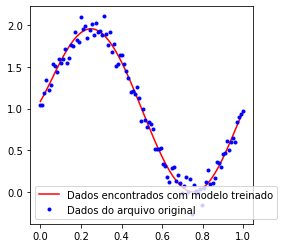

In [25]:
#Modelo treinado utilizado para predição
y_predicted = polynomial_regression.predict(x)

#configuro o gráfico a ser exibido (lambda vs. erro)
fig = plt.figure(figsize=(4,4))
plt.plot(x, y_predicted, 'r', label = 'Dados encontrados com modelo treinado')
plt.plot(x, y, 'b.', label = 'Dados do arquivo original')
plt.legend()
plt.plot()